# Analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector. 
**This notebook focuses on the run 32974, TPC=2, event=32, collection plane.**

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. For these data dead channels (overactivity with no real physical signal) have already been masked.

In [113]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [114]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [115]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [116]:
#Let's see what event IDs exist in the file
triggers = df_32974.event.unique()
print(f"Event {triggers}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [117]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [161]:
event=56
plane=2
TPC=2

### Characteristics of a single run, single event, collection plane hits of a single TPC. 

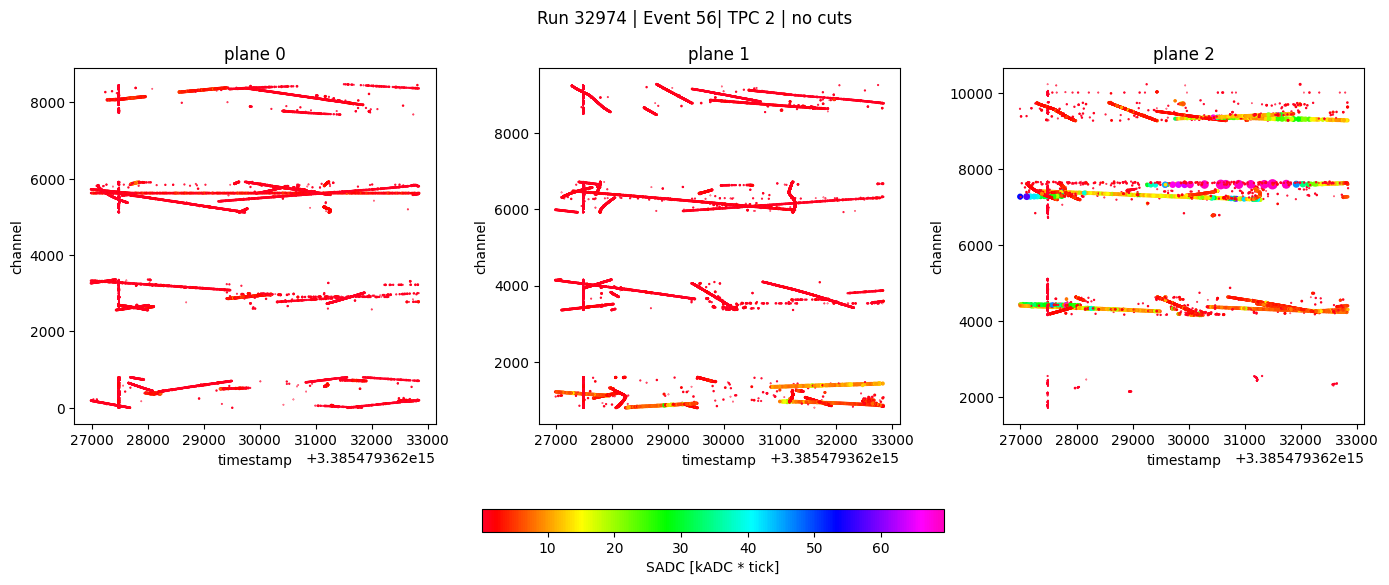

In [ ]:
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974[(df_32974.event == event)]
vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")   
plt.suptitle(f"Run {tps_32974['run'].unique()[0]} | Event {event} | TPC {TPC} | no cuts")
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

- Induction planes appear to be noisier and have less SADC variations.
- Increased noise due to pile-up of simultaneous activity.
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

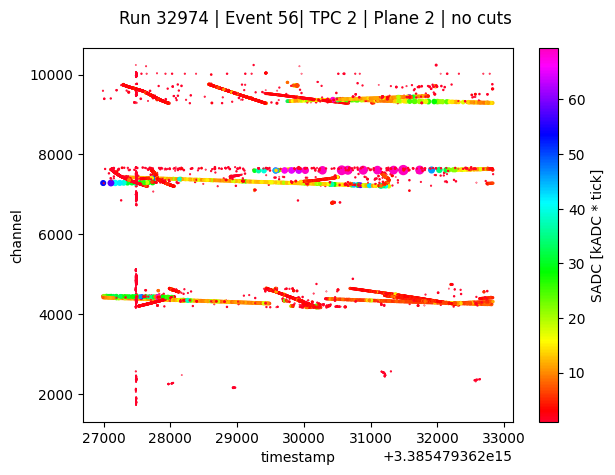

In [ ]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(f"Run {tps_32974['run'].unique()[0]} | Event {event} | TPC {TPC} | Plane {plane} | no cuts")
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [175]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 138.8, mean 4.02704966425947, std deviation 6.5962281779196665
TP_PeakADC: Minimum value 61, maximum 3875, mean 372.8781198530343, std deviation 281.2000937872943
TP_TOT: Minimum value 1, maximum 414, mean 13.710756366400608, std deviation 15.949913116750578


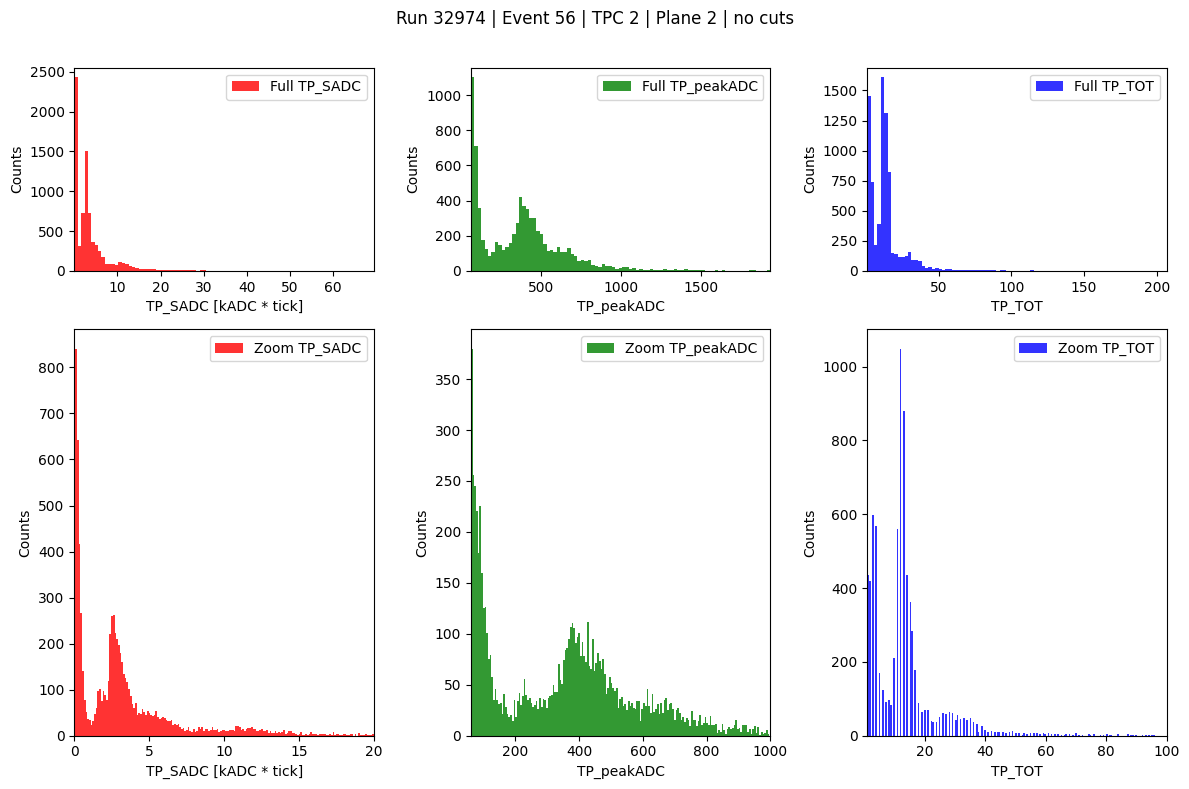

In [183]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(f"Run {tps['run'].unique()[0]} | Event {event} | TPC {TPC} | Plane {plane} | no cuts")

# LEFT: TP_SADC
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=int(2*np.sqrt(len(tps))), alpha=0.8, color='r')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].set_xlim(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3)
axs[0, 0].legend(['Full TP_SADC'])

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 20)
tps_zoom_sadc = tps[mask_sadc]
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=int(2*np.sqrt(len(tps_zoom_sadc))),alpha=0.8, color='r')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(0, 20)
axs[1, 0].legend(['Zoom TP_SADC'])

# CENTRAL: TP_peakADC
axs[0, 1].hist(tps['TP_peakADC'], bins=int(2*np.sqrt(len(tps))), alpha=0.8, color='g')
axs[0, 1].set_xlabel('TP_peakADC')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2)
axs[0, 1].legend(['Full TP_peakADC'])

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=int(2*np.sqrt(len(tps_zoom_adc))), alpha=0.8, color='g')
axs[1, 1].set_xlabel('TP_peakADC')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(61, 1000 )
axs[1, 1].legend(['Zoom TP_peakADC'])

# RIGHT: TP_TOT
axs[0, 2].hist(tps['TP_TOT'], bins=int(2*np.sqrt(len(tps))), alpha=0.8, color='b')
axs[0, 2].set_xlabel('TP_TOT')
axs[0, 2].set_ylabel('Counts')
axs[0, 2].set_xlim(tps['TP_TOT'].min(), tps['TP_TOT'].max()/2)
axs[0, 2].legend(['Full TP_TOT'])

mask_tot = (tps['TP_TOT'] >= 1) & (tps['TP_TOT'] <= 100)
tps_zoom_tot = tps[mask_tot]
axs[1, 2].hist(tps_zoom_tot['TP_TOT'], bins=int(2*np.sqrt(len(tps_zoom_tot))), alpha=0.8, color='b')
axs[1, 2].set_xlabel('TP_TOT')
axs[1, 2].set_ylabel('Counts')
axs[1, 2].set_xlim(1, 100 )
axs[1, 2].legend(['Zoom TP_TOT'])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Clearly a presence of peak at lower energy and lower thresholds (noisier data)

    The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

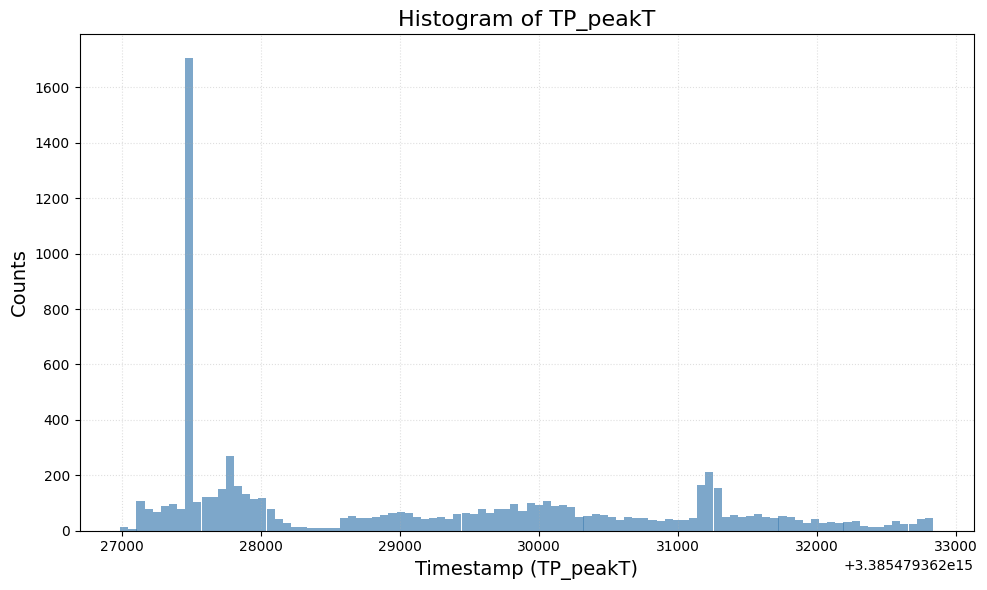

In [ ]:
# Assuming df_32974 is already loaded in your notebook
plt.figure(figsize=(10,6))
plt.hist(tps["TP_peakT"], bins=100, color='steelblue', alpha=0.7)
plt.xlabel("Timestamp (TP_peakT)", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("Time distribution", fontsize=16)
plt.grid(True, linestyle="dotted", alpha=0.4)
plt.tight_layout()
plt.show()